In [11]:
import os
from datetime import datetime
import shutil
from glob import glob
import rioxarray as rxr
from rioxarray.exceptions import NoDataInBounds
import rasterio.features
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
from rasterio.errors import NotGeoreferencedWarning
from scipy.ndimage import gaussian_filter
import importlib.util
from rioxarray.merge import merge_arrays
from scipy.optimize import minimize
from scipy.signal import find_peaks
import warnings
import torch
import pandas as pd
import pickle
import cv2
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
np.seterr(divide='ignore', invalid='ignore')

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

def inline_chart(values, width=10):
    min_val = np.min(values)
    max_val = np.max(values)
    #if len(values) > width resample to 10 values
    if len(values) > width:
        values = np.array_split(values, width)
        values = [np.mean(v) for v in values]
    else:
        #pad with min value
        values = np.pad(values, (0, width-len(values)), "constant", constant_values=min_val)
    #normalize
    values = (values - min_val)/(max_val - min_val)
    chart = ""
    for value in values:
        if value >= 0. and value < 0.125:
            chart+="▁"
        elif value >= 0.125 and value < 0.25:
            chart+="▂"
        elif value >= 0.25 and value < 0.375:
            chart+="▃"
        elif value >= 0.375 and value < 0.5:
            chart+="▄"
        elif value >= 0.5 and value < 0.625:
            chart+="▅"
        elif value >= 0.625 and value < 0.75:
            chart+="▆"
        elif value >= 0.75 and value < 0.875:
            chart+="▇"
        elif value >= 0.875 and value <= 1.:
            chart+="▉"
    return chart

In [12]:
DATA_DIR = "data/rybna_202203240654"
CFG = load_config(f"{DATA_DIR}/config.py").CALIBRATION

In [13]:
#configure logging to file
import logging
log_path = f"{DATA_DIR}/logs/calibration_{datetime.now().strftime('%d%m%Y%H%M%S')}.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path,level=logging.INFO, format='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.handlers.clear()
#logger.addHandler(logging.StreamHandler())
logger.info("Starting procedure")

In [14]:
TMP_DIR = f"{DATA_DIR}/tmp"
recreate_dir(TMP_DIR)
TIF_UNCAL_DIR = f"{DATA_DIR}/tif_uncal"
assert os.path.exists(TIF_UNCAL_DIR), "TIF_UNCAL_DIR does not exist. Please run 1_conversion.ipynb first."
GEOTIF_UNCAL_DIR = f"{DATA_DIR}/geotif_uncal"
assert os.path.exists(GEOTIF_UNCAL_DIR), "geotif_dir does not exist. Please run 1_conversion.ipynb first."
TIF_CAL_DIR = f"{DATA_DIR}/tif_cal"
GEOTIF_CAL_DIR = f"{DATA_DIR}/geotif_cal"
PLOT_CLIP_DIR = f"{DATA_DIR}/plot_clip"
PLOT_CAL_DIR = f"{DATA_DIR}/plot_cal"
CACHE_DIR = f"{DATA_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
# TEMP_OPTIM_DATASET_DIR = f"{DATA_DIR}/temp_optim_dataset"
# I_CLIP_DIR = f"{TEMP_OPTIM_DATASET_DIR}/i_clip"
# J_CLIP_DIR = f"{TEMP_OPTIM_DATASET_DIR}/j_clip"
# CLIP_MASK_DIR = f"{TEMP_OPTIM_DATASET_DIR}/clip_mask"

In [15]:
if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/footprints.pkl"):
    logger.info("Loading footprints from cache")
    with open(f"{CACHE_DIR}/footprints.pkl", "rb") as f:
        footprints = pickle.load(f)
else:
    logger.info("Reading footprints from geotifs")
    geometries = []
    names = []
    for path in tqdm(glob(f"{GEOTIF_UNCAL_DIR}/*.tif")):
        raster = rxr.open_rasterio(path)
        footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
        footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
        assert len(footprints) == 1, "More than one footprint found"
        names.append(os.path.basename(path))
        geometries.append(footprints[0])
    footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries})
    #write CRS
    footprints.crs = CFG.CRS
    with open(f"{CACHE_DIR}/footprints.pkl", "wb") as f:
        pickle.dump(footprints, f)

In [16]:
#erode footprints
footprints["geometry"] = footprints["geometry"].buffer(-CFG.EROSION)

In [17]:
def nan_gaussian_filter(arr, sigma):
    """Apply gaussian filter to array while ignoring nans"""
    V=arr.copy()
    V[np.isnan(arr)]=0
    VV=gaussian_filter(V,sigma=sigma)
    W=0*arr.copy()+1
    W[np.isnan(arr)]=0
    WW=gaussian_filter(W,sigma=sigma)
    Z=VV/WW
    Z[np.isnan(arr)]=np.nan
    return Z


In [18]:

if CFG.CACHE and os.path.exists(f"{CACHE_DIR}/calibration_pairs.pkl"):
    logger.info("Loading cached pairs")
    with open(f"{CACHE_DIR}/calibration_pairs.pkl", "rb") as f:
        pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks = pickle.load(f)
else:
    logger.info("Generating temprature global optimization dataset")
    # recreate_dir(TEMP_OPTIM_DATASET_DIR)
    # recreate_dir(I_CLIP_DIR)
    # recreate_dir(J_CLIP_DIR)
    # recreate_dir(CLIP_MASK_DIR)
    pairs_i = []
    pairs_j = []
    pairs_area = []
    i_clips = []
    j_clips = []
    masks = []
    # idx = 0
    for i in tqdm(range(len(footprints))):
        i_raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{footprints.iloc[i]['name']}", masked=True)
        for j in range(i+1, len(footprints)):
            if footprints.iloc[i].geometry.intersects(footprints.iloc[j].geometry):
                intersection = footprints.iloc[i].geometry.intersection(footprints.iloc[j].geometry)
                if intersection.area < CFG.MIN_INTERSECTION_AREA:
                    logger.info(f"i ({i}), j ({j}): intersection area too small")
                    continue
                j_raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{footprints.iloc[j]['name']}", masked=True)
                try:
                    i_clip = i_raster.rio.clip([intersection])
                    j_clip = j_raster.rio.clip([intersection])
                except NoDataInBounds:
                    logger.info(f"i ({i}), j ({j}): NoDataInBounds")
                    continue
                j_clip = j_clip.rio.reproject_match(i_clip)
                i_clip = i_clip.values[0]
                j_clip = j_clip.values[0]
                i_clip = nan_gaussian_filter(i_clip, sigma=CFG.GAUSS_SIGMA)
                j_clip = nan_gaussian_filter(j_clip, sigma=CFG.GAUSS_SIGMA)
                i_var = np.nanvar(i_clip)
                j_var = np.nanvar(j_clip)
                var = np.nanmean([i_var, j_var])
                if np.isnan(var):
                    logger.info(f"i ({i}), j ({j}): var is nan")
                    continue
                mask = (~np.isnan(i_clip) & ~np.isnan(j_clip)).astype(np.int16)
                i_clip[np.isnan(i_clip)] = np.nanmean(i_clip)
                j_clip[np.isnan(j_clip)] = np.nanmean(j_clip)

                i_clip = cv2.resize(i_clip, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_LINEAR)
                j_clip = cv2.resize(j_clip, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_LINEAR)
                mask = cv2.resize(mask, (CFG.CLIP_SIZE, CFG.CLIP_SIZE), interpolation=cv2.INTER_NEAREST)
                #assert i_clip, j_clip, mask dont have nans
                if np.isnan(i_clip).any():
                    logger.info(f"i ({i}), j ({j}): i_clip has nan")
                    continue
                if np.isnan(j_clip).any():
                    logger.info(f"i ({i}), j ({j}): j_clip has nan")
                    continue
                if np.isnan(mask).any():
                    logger.info(f"i ({i}), j ({j}): mask has nan")
                    continue
                #np.save(f"{I_CLIP_DIR}/{idx}.npy", i_clip)
                #np.save(f"{J_CLIP_DIR}/{idx}.npy", j_clip)
                #np.save(f"{CLIP_MASK_DIR}/{idx}.npy", mask)
                pairs_i.append(i)
                pairs_j.append(j)
                pairs_area.append(intersection.area)
                i_clips.append(i_clip)
                j_clips.append(j_clip)
                masks.append(mask)
                # idx += 1
    pairs_i = np.array(pairs_i)
    pairs_j = np.array(pairs_j)
    pairs_area = np.array(pairs_area)
    i_clips = np.array(i_clips)
    j_clips = np.array(j_clips)
    masks = np.array(masks)
    #pickle dump
    with open(f"{CACHE_DIR}/calibration_pairs.pkl", "wb") as f:
        pickle.dump((pairs_i, pairs_j, pairs_area, i_clips, j_clips, masks ), f)

In [24]:
n_images = len(footprints)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pairs_i = torch.tensor(pairs_i, dtype=torch.int64, device=device) # (n_pairs,)
pairs_j = torch.tensor(pairs_j, dtype=torch.int64, device=device) # (n_pairs,)
pairs_area = torch.tensor(pairs_area, dtype=torch.float32, device=device) # (n_pairs,)
#pairs_var = torch.tensor(pairs_var, dtype=torch.float32, device=device) # (n_pairs,)
i_clips = torch.tensor(i_clips, dtype=torch.float32, device=device) # (n_pairs, width, height)
j_clips = torch.tensor(j_clips, dtype=torch.float32, device=device) # (n_pairs, width, height)
masks = torch.tensor(masks, dtype=torch.float32, device=device) # (n_pairs, width, height)
pairs_n_pixels = torch.sum(masks, dim=(1, 2)) # (n_pairs,)
n_pixels = torch.sum(pairs_n_pixels) # (1,)
n_pairs = len(pairs_i) # (1,)
i_clips_mean = torch.sum(i_clips * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
j_clips_mean = torch.sum(j_clips * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
i_clips_var = torch.sum(masks * (i_clips - i_clips_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
j_clips_var = torch.sum(masks * (j_clips - j_clips_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
a_coefs = torch.ones(n_images, dtype=torch.float32, device=device, requires_grad=True) # (n_images,)
b_coefs = torch.zeros(n_images, dtype=torch.float32, device=device, requires_grad=True) # (n_images,)

optimizer = torch.optim.Adam([a_coefs, b_coefs], lr=CFG.INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=CFG.LR_PLATEAU_FACTOR, patience=CFG.LR_PLATEAU_PATIENCE, cooldown=CFG.LR_PLATEAU_COOLDOWN, verbose=True)

best_loss = np.inf
es_counter = 0
pixel_losses = []
mean_losses = []
var_losses = []
for epoch in (pbar := tqdm(range(CFG.EPOCHS))):
    pbar.set_description(f"Epoch {epoch}")
    optimizer.zero_grad()
    i_clips_cal = a_coefs[pairs_i, None, None] * i_clips + b_coefs[pairs_i, None, None] # (n_pairs, width, height)
    j_clips_cal = a_coefs[pairs_j, None, None] * j_clips + b_coefs[pairs_j, None, None] # (n_pairs, width, height)
    i_clips_cal_mean = torch.sum(i_clips_cal * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    j_clips_cal_mean = torch.sum(j_clips_cal * masks, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    i_clips_cal_var = torch.sum(masks * (i_clips_cal - i_clips_cal_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    j_clips_cal_var = torch.sum(masks * (j_clips_cal - j_clips_cal_mean[:, None, None]) ** 2, dim=(1, 2)) / pairs_n_pixels # (n_pairs,)
    
    # clips_cal = torch.stack([i_clips, j_clips], axis=1)
    # clips_cal_mean = torch.sum(clips_cal * masks[:, None, :, :], axis=(1, 2, 3)) / 2. / pairs_n_pixels # (n_pairs,)
    # clips_cal_var = torch.sum((clips_cal - clips_cal_mean[:, None, None, None])**2 * masks[:, None, :, :], axis=(1, 2, 3)) / 2. / pairs_n_pixels # (n_pairs,)
    
    # i_clips_cal_mean = torch.sum(i_clips_cal * masks)/n_pixels # (n_pairs,)
    # j_clips_cal_mean = torch.sum(j_clips_cal * masks)/n_pixels # (n_pairs,)
    # i_clips_cal_var = torch.sum((i_clips_cal - i_clips_cal_mean[None, None, None])**2 * masks)/n_pixels # (n_pairs,)
    # j_clips_cal_var = torch.sum((j_clips_cal - j_clips_cal_mean[None, None, None])**2 * masks)/n_pixels # (n_pairs,)
    # clips_cal_var = 0.5*(i_clips_cal_var + j_clips_cal_var) 
    
    pixel_loss = torch.sum((i_clips_cal - j_clips_cal)**2 * masks)/n_pixels
    #abs_loss = 0.1*(torch.sum((i_clips_cal - i_clips)**2 * masks)/n_pixels + torch.sum((j_clips_cal - j_clips)**2 * masks)/n_pixels)
    mean_loss = 0.01*(torch.sum((i_clips_cal_mean - i_clips_mean)**2)/n_pairs + torch.sum((j_clips_cal_mean - j_clips_mean)**2)/n_pairs)
    var_loss = 0.5*(torch.sum((i_clips_cal_var - i_clips_var)**2)/n_pairs + torch.sum((j_clips_cal_var - j_clips_var)**2)/n_pairs)
    loss = pixel_loss + mean_loss + var_loss
    
    if best_loss-loss.item() > CFG.ES_MIN_DELTA:
        best_loss = loss.item()
        best_a_coefs = a_coefs.detach().cpu().numpy()
        best_b_coefs = b_coefs.detach().cpu().numpy()
        es_counter = 0
    else:
        es_counter += 1
        if es_counter > CFG.ES_PATIENCE:
            print("Early stopping")
            break
    pixel_losses.append(pixel_loss.item())
    mean_losses.append(mean_loss.item())
    var_losses.append(var_loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    pbar.set_postfix({"pixel_loss": pixel_loss.item(), "mean_loss": mean_loss.item(), "var_loss": var_loss.item(), "loss": f"{loss.item()}", "a_mean": a_coefs.mean().item(), "b_mean": b_coefs.mean().item()})

/tmp/ipykernel_29144/1149997951.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pairs_i = torch.tensor(pairs_i, dtype=torch.int64, device=device) # (n_pairs,)
/tmp/ipykernel_29144/1149997951.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pairs_j = torch.tensor(pairs_j, dtype=torch.int64, device=device) # (n_pairs,)
/tmp/ipykernel_29144/1149997951.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pairs_area = torch.tensor(pairs_area, dtype=torch.float32, device=device) # (n_pairs,)
/tmp/ipykernel_29144/1149997951.py:8: UserWarni

Epoch 01316: reducing learning rate of group 0 to 1.0000e-03.


Epoch 1367:  14%|█▎        | 1367/10000 [19:08<1:48:51,  1.32it/s, pixel_loss=0.778, mean_loss=0.12, var_loss=0.798, loss=1.6959532499313354, a_mean=0.67, b_mean=0.139]

Epoch 01367: reducing learning rate of group 0 to 1.0000e-04.


Epoch 1418:  14%|█▍        | 1418/10000 [19:49<2:18:13,  1.03it/s, pixel_loss=0.778, mean_loss=0.12, var_loss=0.798, loss=1.6959497928619385, a_mean=0.67, b_mean=0.139]

Epoch 01418: reducing learning rate of group 0 to 1.0000e-05.


Epoch 1469:  15%|█▍        | 1469/10000 [20:31<1:52:23,  1.27it/s, pixel_loss=0.778, mean_loss=0.12, var_loss=0.798, loss=1.6959493160247803, a_mean=0.67, b_mean=0.139]

Epoch 01469: reducing learning rate of group 0 to 1.0000e-06.


Epoch 1520:  15%|█▌        | 1520/10000 [21:08<1:39:42,  1.42it/s, pixel_loss=0.778, mean_loss=0.12, var_loss=0.798, loss=1.6959491968154907, a_mean=0.67, b_mean=0.139]

Epoch 01520: reducing learning rate of group 0 to 1.0000e-07.


Epoch 1545:  15%|█▌        | 1545/10000 [21:28<1:57:29,  1.20it/s, pixel_loss=0.778, mean_loss=0.12, var_loss=0.798, loss=1.6959491968154907, a_mean=0.67, b_mean=0.139]

Early stopping


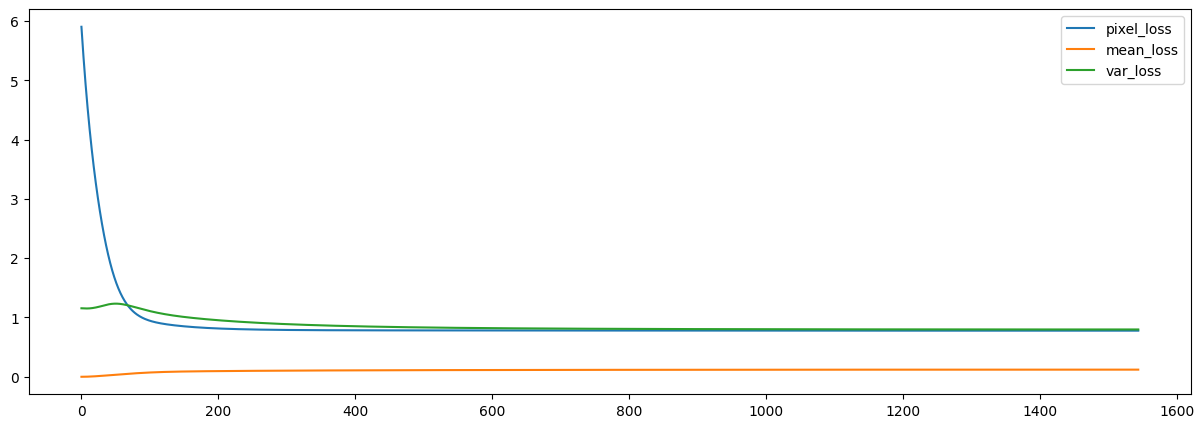

In [25]:
#plot losses with log scale
plt.figure(figsize=(15, 5))
plt.plot(pixel_losses, label="pixel_loss")
plt.plot(mean_losses, label="mean_loss")
plt.plot(var_losses, label="var_loss")
#plt.yscale("log")
plt.legend()
plt.show()

In [26]:
recreate_dir(GEOTIF_CAL_DIR)
# recreate_dir(TIF_CAL_DIR)
for name, a, b in zip(tqdm(footprints["name"].values, desc="Saving calibrated rasters"), best_a_coefs, best_b_coefs):
    geotif = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{name}", masked=True)
    geotif.values = a * geotif.values + b
    geotif.rio.to_raster(f"{GEOTIF_CAL_DIR}/{name}")
    # tif = rxr.open_rasterio(f"{TIF_UNCAL_DIR}/{name}", masked=True)
    # tif.values = a * tif.values + b
    # tif.rio.to_raster(f"{TIF_CAL_DIR}/{name}")
    # os.system(f"exiftool -tagsfromfile {TIF_UNCAL_DIR}/{name} {TIF_CAL_DIR}/{name} -overwrite_original_in_place")

Saving calibrated rasters: 100%|██████████| 891/891 [03:11<00:00,  4.65it/s]
